# Order execution behaviour

This notebook serves to investigate the relationship between the limit price positioning and the execution of the corresponding limit order.
The demonstrated methods are based on [1] with the goal to either produce similar results or else to draw a conculsion regarding the differing behaviour, using BTC/USD market data from Bitfinex (https://www.bitfinex.com/t/BTC:USD).

As a first step, the **expected execution price** is investigated with respect to the placement of the limit order.
Based on this analysis the standard deviation of the resulted prices will uncover the **risk** that comes along with limit order placement.
Finally, by combining the previous two results, an **efficient pricing frontier** can be drawn which highlights the trade-off between risk and returns.

Important to note is that the results are heavily affected by the underlying matching engine. 
The match engine was developed as part of this project (see https://github.com/backender/ctc-executioner/blob/master/match_engine.py).
Since there is no way to determine the true resulted trades given an order which was to be executed in the past, the assumption made in this notebook is as follows: every entry in the orderbook, which satisfies the requirements defined by the order, results in a trade. Further more, the limitation of 25 orderbook levels on each, bid and ask, side is overcome by estimated, yet imaginary, entries with the use of *linear extrapolation*.

In [1]:
%cd ..

/Volumes/Data/dev/ctc-executioner


In [2]:
from action_space import ActionSpace
from orderbook import Orderbook
from order_side import OrderSide
from order_type import OrderType
import matplotlib.pyplot as plt
import numpy as np

Order book data from Bitfinex containing approximately 1 hour worth of data is loaded.

In [3]:
orderbook = Orderbook()
orderbook.loadFromBitfinexFile('orderbook_bitfinex_btcusd_view.tsv')

## Expected Execution Price

The task is to execute *I* shares within *T* seconds, and evealuate achieved *returns*.
According to [1] there are 3 obvious trading strategies in order to determine the execution price of an order (considering limit and market order types only):

1. "Submit a market order tor the entire amount immediately"
2. "Wait until the end of the time period and then go to the market with the entire amount"
3. "Submit a limit order at the beginning of the time period; then submitting a market order for the remainder of shares (if any) at the end of the interval". 

Strategy 3 is implemented as shown below. The function accepts the list of *levels* (in our case we define the levels as 1 basis point) to explore within the book.
The *crossval* parameter indicates how many times the paid/received price shall be evaulated per level.
The *force_execution* parameter expresses whether the order shall be enforced to execute after the given time is consumed.

The function plots a chart which demonstrates the (enforced, e.g. to be fully filled) execution of orders.
On the x-axis, the limit order level (e.g. number of basis points) relative to its side of the market is plotted, whereas the y-axis shows the achieved returns.
Returns are expressed in two ways, namely, the (volume weighted) price paid in comparison to:
1. red: bid-/ask mid price at t=0 (e.g. beginning of period)
2. green: bid-/ask mid price at t=T (e.g. end of period)

Like the authors of [1], we prefer to draw conclusions of an execution compared to the price at the beginning of the period (1).
However, as we shall see below, the results tend to be much more noisy – probably due to high price fluctuations BTC undergoes currently.

In [4]:
def evaluateReturns(levels=range(-100, 51), crossval=10, force_execution=True):
    t = T[-1]
    i = I[-1]
    ys = []
    ys2 = []
    for level in levels:
        profit = []
        profit2 = []
        a = level
        for _ in range(crossval):
            action = actionSpace.createAction(a, t, i, force_execution=force_execution)
            refBefore = action.getReferencePrice()
            action.run(actionSpace.orderbook)
            refAfter = action.getOrderbookState().getTradePrice()
            paid = action.getAvgPrice()
            if paid == 0.0:
                assert force_execution == False
                continue
            elif action.getOrder().getSide() == OrderSide.BUY:
                profit.append(refBefore - paid)
                profit2.append(refAfter - paid)
            else:
                profit.append(paid - refBefore)
                profit2.append(paid - refAfter)

        ys.append(profit)
        ys2.append(profit2)
    x = levels
    return (x, ys, ys2)


def reject_outliers(data, m=1.5):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def priceReturnCurve(levels=range(-100, 51), crossval=10, force_execution=True):
    (x, ys, ys2) = evaluateReturns(levels, crossval, force_execution)
    y = [np.mean(reject_outliers(np.array(x))) for x in ys]
    y2 = [np.mean(reject_outliers(np.array(x))) for x in ys2]
    plt.plot(x, y, 'r-')
    plt.plot(x, y2, 'g-')
    plt.show()

We now try to replicate the pattern presented in [1] (section IV.A):
![price-return.png](img/price-return.png)

First off, a runtime of 60 seconds in order to aquire 100 BTC is choosen.

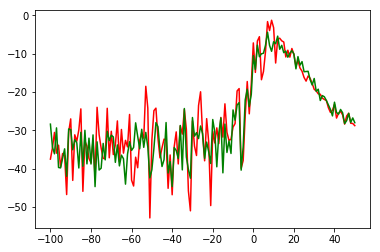

In [5]:
T = [0, 60] #, 120, 240
I = [100.0]
actionSpace = ActionSpace(orderbook, OrderSide.BUY, T, I)
priceReturnCurve(crossval=10, force_execution=True)

Market orders dominate the orders where the price was set deep in the book (range [-50...~-5]).
Further does the chart suggest to aquire the quantity by buying part of the ask book (e.g. up to a level around +15).
By setting a price too high in the sell book (e.g. level >15), a trader is willing to pay a premium at the very beginning of the period and hence misses out on opportunities to buy of less over the course of the time horizon. 

The same behaviour occurs when selling 100 BTC.

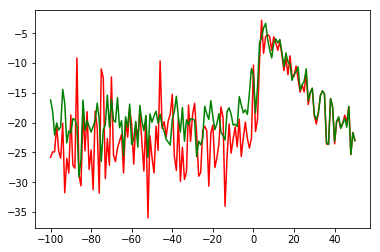

In [6]:
T = [0, 60] #, 120, 240
I = [100.0]
actionSpace = ActionSpace(orderbook, OrderSide.SELL, T, I)
priceReturnCurve(crossval=10, force_execution=True)

Both graphs above indicate that better prices are achieved when allowing to cross the spread and buy/sell for a higher/lower price. This is clearly due to the fact that 100 BTC is a large volume to be executed within only 1 minute.

*On a side note, the comparison to the price before the time period (e.g. red line) tends to produce better results than when comparing to the price at the end of the time period. 
In the buy scenario before, this was exactly the opposite. 
Hence, the market data in use consists of a slight downward trend*.

We now decrease the inventory to 10 BTC and see that the price differences resulted by the defined price levels become less significant.
Hence, the suggested level to place an order gets slightly shifted towards the negative, in fact, one should not cross the spread and place orders at levels ~[-3; 0].

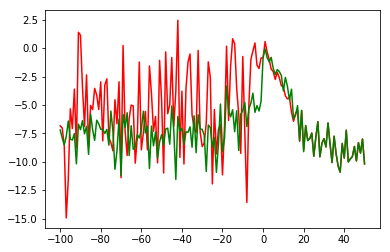

In [7]:
T = [0, 60] #, 120, 240
I = [10.0]
actionSpace = ActionSpace(orderbook, OrderSide.BUY, T, I)
priceReturnCurve(crossval=25, force_execution=True)

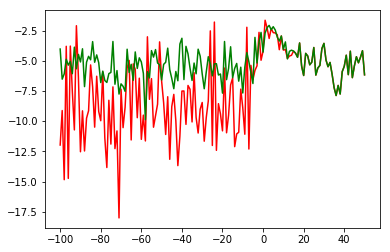

In [8]:
T = [0, 60] #, 120, 240
I = [10.0]
actionSpace = ActionSpace(orderbook, OrderSide.SELL, T, I)
priceReturnCurve(crossval=25, force_execution=True)

The following two figures present the same results for an inventory of only 1 BTC.
At this point, the evolved prices remain more or less constant and price placement has almost no effect.
The reason for this stationary behaviour can be explained as follows:
1. The volume of the orderbook at each level mostly exceeds 1 BTC, thus setting a high price limit has no effect since the order will be filled using the best ask (e.g. ask closest to the spread) entry almost always.
2. Price fluctuation within 60 seconds is not as high. If an order with price setting deep in the book is beeing filled with a market order after the time is consumed, this very market order will not differ much from an order with price placement above the spread (as described in 1).

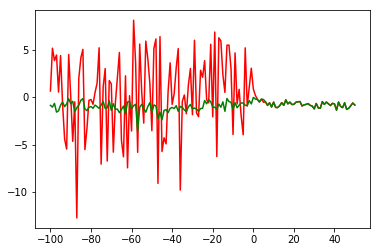

In [9]:
T = [0, 60]
I = [1.0]
actionSpace = ActionSpace(orderbook, OrderSide.BUY, T, I)
priceReturnCurve(crossval=25, force_execution=True)

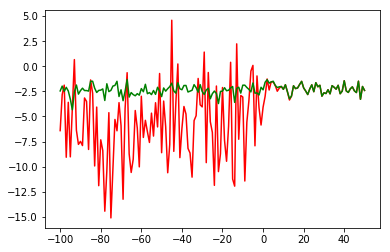

In [10]:
T = [0, 60]
I = [1.0]
actionSpace = ActionSpace(orderbook, OrderSide.SELL, T, I)
priceReturnCurve(crossval=25, force_execution=True)

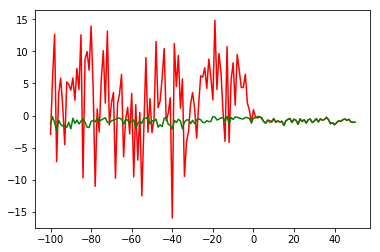

In [11]:
T = [0, 120]
I = [1.0]
actionSpace = ActionSpace(orderbook, OrderSide.BUY, T, I)
priceReturnCurve(crossval=25, force_execution=True)

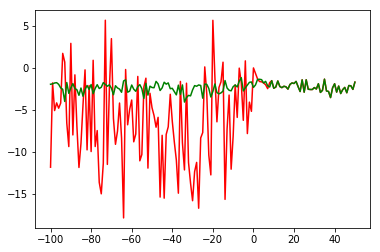

In [12]:
T = [0, 120]
I = [1.0]
actionSpace = ActionSpace(orderbook, OrderSide.SELL, T, I)
priceReturnCurve(crossval=25, force_execution=True)

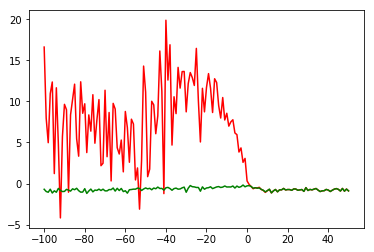

In [13]:
T = [0, 300]
I = [1.0]
actionSpace = ActionSpace(orderbook, OrderSide.BUY, T, I)
priceReturnCurve(crossval=100, force_execution=True)

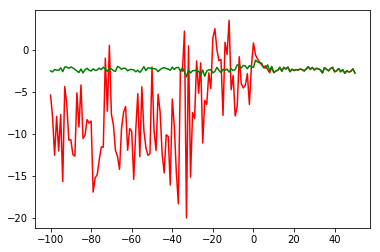

In [14]:
T = [0, 300]
I = [1.0]
actionSpace = ActionSpace(orderbook, OrderSide.SELL, T, I)
priceReturnCurve(crossval=100, force_execution=True)

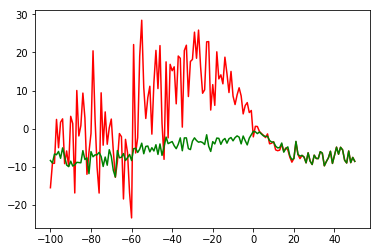

In [15]:
T = [0, 600]
I = [10.0]
actionSpace = ActionSpace(orderbook, OrderSide.BUY, T, I)
priceReturnCurve(crossval=25, force_execution=True)

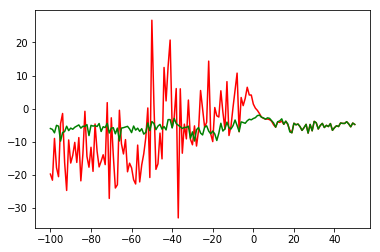

In [16]:
T = [0, 600]
I = [10.0]
actionSpace = ActionSpace(orderbook, OrderSide.SELL, T, I)
priceReturnCurve(crossval=25, force_execution=True)

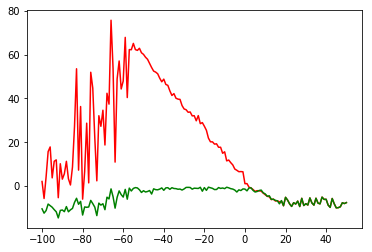

In [17]:
T = [0, 1800] #, 120, 240
I = [10.0]
actionSpace = ActionSpace(orderbook, OrderSide.BUY, T, I)
priceReturnCurve(crossval=25, force_execution=True)

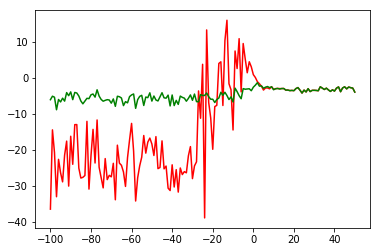

In [18]:
T = [0, 1800] #, 120, 240
I = [10.0]
actionSpace = ActionSpace(orderbook, OrderSide.SELL, T, I)
priceReturnCurve(crossval=25, force_execution=True)

## Risk


In [19]:
def priceRiskCurve(levels=range(-100, 51), crossval=10, force_execution=True):
    (x, ys, ys2) = evaluateReturns(levels, crossval, force_execution)
    y = [np.std(x) for x in ys]
    y2 = [np.std(x) for x in ys2]
    plt.plot(x, y, 'r-')
    #plt.plot(x, y2, 'g-')
    plt.show()

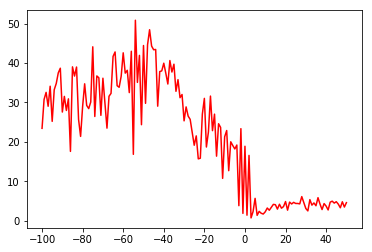

In [20]:
T = [0, 600]
I = [10.0]
actionSpace = ActionSpace(orderbook, OrderSide.BUY, T, I)
priceRiskCurve(crossval=10, force_execution=True)

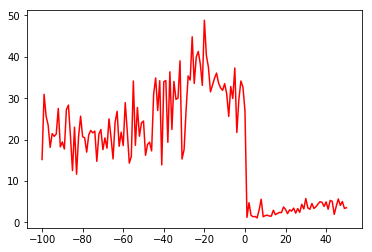

In [21]:
T = [0, 1800]
I = [100.0]
actionSpace = ActionSpace(orderbook, OrderSide.SELL, T, I)
priceRiskCurve(crossval=10, force_execution=True)

## References

[1] Electronic Trading in Order-Driven Markets: Efficient Execution (http://ieeexplore.ieee.org/document/1524045/)